<a href="https://colab.research.google.com/github/01Joseph-Hwang10/AI_fundamentals/blob/main/unist_aip2_20211381.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm, tqdm_notebook
import tensorflow as tf
from sklearn.model_selection import train_test_split

from glob import glob
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow import keras

from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#Mount your google drive
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
## PLEASE MODIFY THIS ##

#Train Method : ResNet50

#Upload train dataset
train_dataset_path = '/content/gdrive/MyDrive/train.npy' #Type your train dataset path. Check your own dataset path before typing it. /// ex) /content/gdrive/Mydrive/homeworks/AIP2/train.npy
test_dataset_path = '/content/gdrive/MyDrive/test.npy' #Type your test dataset path. Check your own dataset path before typing it. /// ex) /content/gdrive/Mydrive/homeworks/AIP2/test.npy
#You can refer the tutorial ppt if you want to know more details about this

valid_ratio = 0.2 # Type the ratio for splition train data into train and valid. /// ex) the number of data = 100, valid_ratio = 0.2 --> the number of train data = 80, the number of valid data = 20 
batch_size = 32 #Type your own batch size
n_epoch = 50 #Type your Own Epoch num

In [ ]:
train_np_data = np.load(train_dataset_path, allow_pickle=True) #Upload train data. train_np_data consists of img(data) and label(target). 
data, target = train_np_data.item().get('data'), train_np_data.item().get('target') #Get img data(data) and label(target) from train_np_data. 

#Explore the dataset
print(f"total number of img data : {data.shape[0]}") 
print(f"total number of label data : {target.shape[0]}")

sample_data, sample_target = data[0], target[0]
print(sample_data.shape) # (64, 64, 3) --> img size is 64 x 64 and its type is RGB image(3 channel).
print(sample_target.shape) # (13, ) --> one-hot encoding for label. /// ex)  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] --> the solution label is the 4th label.

X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=valid_ratio) # Split train data into train and valid according to the split ratio.

total number of img data : 4573
total number of label data : 4573
(64, 64, 3)
(13,)


In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)

In [ ]:
### Test method ###

test_np_data = np.load(test_dataset_path, allow_pickle=True) #Upload test data. test_np_data consists of img(data) and img name(name).
test_data, name = test_np_data.item().get('data'), test_np_data.item().get('name') ##Get img data(data) and name from test_np_data.
#name will be used for creating result.csv file. So, Consider only data.

#Explore the dataset
print(f"total number of img data : {test_data.shape[0]}") 
print(f"shape of img : {test_data.shape[1:]}")

total number of img data : 1105
shape of img : (64, 64, 3)


Genre : Symbolism


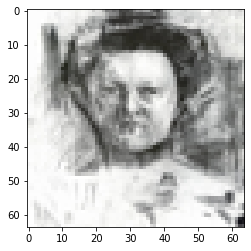

In [ ]:
#Visualize the image sample
%matplotlib inline

genre_dict = {'0': 'Symbolism', '1': 'High Renaissance', '2': 'Post-Impressionism', '3': 'Pop Art', '4': 'Impressionism', '5': 'Northern Renaissance', '6': 'Surrealism', 
         '7': 'Expressionism', '8': 'Romanticism', '9': 'Early Renaissance', '10': 'Baroque', '11': 'Cubism', '12': 'Primitivism'} # Dictionary used for converting one-hot encoding to genre name.

img_order = 0 # You can select any image you want by changing the variable 'img_order'.
sample_data = data[img_order] #Get the image in data. 
sample_data = sample_data.astype(np.int)
sample_target = target[img_order] #Get the target about the selected image. it is the state of one-hot encoding.
sample_genre = genre_dict[str(np.argmax(sample_target))] #Convert one-hot encoding to genre name

print(f"Genre : {sample_genre}")
plt.imshow(sample_data)

In [ ]:
STEP_SIZE_TRAIN = X_train.shape[0]//batch_size
STEP_SIZE_VALID = X_valid.shape[0]//batch_size

print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Total number of batches = 114 and 28


In [ ]:
class ResidualBlock50():

  def _main_layers(self, filters, strides):
    return [
                   Conv2D(filters, (1,1), strides=strides, padding='valid', use_bias=False, kernel_initializer="he_normal"),
                   BatchNormalization(),
                   self.activation,
                   Conv2D(filters, (3,3), strides=1, padding='same', use_bias=False, kernel_initializer="he_normal"),
                   BatchNormalization(),
                   self.activation,
                   Conv2D(filters * 4, (1,1), strides=1, padding='valid', use_bias=False, kernel_initializer="he_normal"),
                   BatchNormalization(),
    ]
  
  def _skip_layers(self, filters, strides):
    return [
                   Conv2D(filters * 4, (1,1), strides=strides, padding='valid', use_bias=False, kernel_initializer="he_normal"),
                   BatchNormalization(),
    ]

  def __init__(self, filters, n, downsample=False, activation='relu', **kwargs):
    super(ResidualBlock50, self).__init__(**kwargs)
    self.activation = keras.activations.get(activation)
    self.filters = filters
    self.n = n
    self.downsample = downsample

  def __call__(self, inputs):
    shortcut = inputs
    out = inputs
    downsampled=False
    strides=2 if self.downsample else 1
    for iter in range(self.n):
      layers = self._main_layers(self.filters, strides=(strides if not downsampled else 1))
      for layer in layers:
        out = layer(out)
      if not downsampled:
        skip_layers = self._skip_layers(self.filters, strides=strides)
        for layer in skip_layers:
          shortcut = layer(shortcut)
      downsampled=True
      out = Add()([out, shortcut])
      out = self.activation(out)
    return out

In [ ]:
class ResNet50():

  def _initial_layer(self):
    return [
            Conv2D(64, (7,7), strides=2, input_shape=[64,64,3], padding='same', use_bias=False),
            BatchNormalization(),
            Activation('relu'),
            MaxPooling2D(pool_size=3, strides=2)
    ]
  def build_model(n1, n2, n3, n4):
    model = Sequential([
                        Dense(n1),
                        Dense(n2),
                        ...
    ])


    analyze_model(model)
  def _last_layer(self):
    # model = Sequential([
    #  
    ])
    # 
    return [
            GlobalAveragePooling2D(),
            Flatten(),
            Dense(len(genre_dict.keys()), activation='softmax')
    ]

  def __init__(self, **kwargs):
    self.layers = [
                *self._initial_layer(),
                ResidualBlock50(64, 3),
                ResidualBlock50(128, 4, downsample=True),
                ResidualBlock50(256, 6, downsample=True),
                ResidualBlock50(512, 3, downsample=True),
                *self._last_layer(),
    ]

  def build(self) -> Model:
    inputs = keras.Input(shape=(64,64,3), dtype="float32")
    outputs = inputs
    for layer in self.layers:
      outputs = layer(outputs)
    return Model(inputs, outputs)

In [ ]:
## PLEASE MODIFY THIS ##
model = ResNet50().build()
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Complie your model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Learning rate scheduling
def exponential_decay(epoch, lr):
  return lr * 0.1 ** (1 / 20)
lr_scheduler = callbacks.LearningRateScheduler(exponential_decay)

# Early stopping
earlystopping = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Training
history = model.fit(train_generator, epochs=n_epoch, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[earlystopping, lr_scheduler])
score = model.evaluate(X_valid, y_valid)

NameError: ignored

In [ ]:
# Example of model prediction
output = model.predict(test_data) #Predict the result with your trained model.
output = np.argmax(output, axis = -1) #Convert one-hot encoding to label
print(output)

[ 3  2 10 ...  3 11  7]


In [ ]:
# Save your result to csv file.
data = {
    'img' : name,
    'predictions' : output
}

# You should submit the saved `result.csv' to the codalab.

def _key(_str): #extract the order from img_name 
  # print(_str)
  str2int = int(_str.split('_')[1].split('.')[0])
  return str2int
  
output_df = pd.DataFrame(data) # Create dataframe 
output_df['order'] = output_df['img'].apply(_key) #the 'order' column is used for sorting output in descending order.
output_df = output_df.sort_values(by = 'order')
output_df = output_df[['img', 'predictions']].reset_index(drop = True) #Extract colunms necessary to evaluate in Codalab.

print(output_df)
output_df.to_csv('result.csv')

                img  predictions
0        test_0.jpg            3
1        test_1.jpg            2
2        test_2.jpg            4
3        test_3.jpg            3
4        test_4.jpg            4
...             ...          ...
1100  test_1100.jpg           12
1101  test_1101.jpg            3
1102  test_1102.jpg           11
1103  test_1103.jpg            2
1104  test_1104.jpg            4

[1105 rows x 2 columns]
